In [1]:
%matplotlib inline
from numpy import *
from pylab import *
from numpy.polynomial.polynomial import *
from numpy.polynomial.chebyshev import chebgauss


In [2]:


#INTRODUCIAMO chebishev per produrre lo spazio duale

def chebyshev_nodes(num_nodes):
    #cheb = [0.5*cos((2*(i+1)-1)*pi/(2*x)) + 0.5 for i in range(num_nodes)]
    #cheb = array(cheb)
    cheb = 0.5 * chebgauss(num_nodes)[0] + 0.5
    return sort(cheb)

def lagrange_basis(nodes, i):
    num = arange(len(nodes))
    d = product([ (nodes[i]-nodes[j]) for j in num if j != i], axis=0)
    def func(x):
        L = product([ (x - nodes[j]) for j in num if j != i], axis=0) / d
        return L
    return func

def lagrange_basis_derivatives(nodes, i):
    num = arange(len(nodes))
    d = product([ (nodes[i]-nodes[j]) for j in num if j != i], axis=0)
    def func(x):
        L_deriv = sum( [ product( [ (x - nodes[j]) for j in num if (j != i and j != k) ], axis=0) for k in num if k != i ], axis=0 ) / d
        return L_deriv
    return func



In [3]:
from numpy.polynomial.legendre import leggauss

dim = 3
degree = 5 #grado dei polinomi delle basi 

num_q = degree + 1
q,w = leggauss(num_q) # Gauss between -1 and 1
q = (q+1)/2 # to go back to 0,1
w = w/2

In [10]:
cheb = chebyshev_nodes(degree+1) #Lista nodi chebichev

n = degree + 1 # Dim poly space


lag_bas=[]
lag_bas_deriv=[]
V = []
V_prime=[]

#lagrangian base per i punti chebichev
for i in range(len(cheb)):
    lag_bas.append(lagrange_basis(cheb,i))
    lag_bas_deriv.append(lagrange_basis_derivatives(cheb,i))


Vq = zeros((n, len(q)))
Vpq = zeros((n, len(q)))

    #Le righe di Vq sono le funzioni di base calcolate sui punti di quadratura
for i in range(n):
    Vq[i] = lag_bas[i](q)
    Vpq[i] = lag_bas_deriv[i](q)
    
latticeq_points = array([[[[qx,qy,qz] for qz in q] for qy in q ] for qx in q])
latticeq_points = latticeq_points.reshape(len(q)*len(q)*len(q),dim)

lpoint_x = array([latticeq_points[i,0] for i in range(len(latticeq_points))])
lpoint_y = array([latticeq_points[i,1] for i in range(len(latticeq_points))])
lpoint_z = array([latticeq_points[i,2] for i in range(len(latticeq_points))])



In [13]:

# -------------------------------------------------

A1 = einsum('jq, iq, q -> ji', Vpq, Vpq, w, optimize=True)
M1 = einsum('jq, iq, q -> ji', Vq, Vq, w, optimize=True)

A = einsum('il, jm, kn -> ijklmn', A1, M1, M1, optimize=True)
A += einsum('il, jm, kn -> ijklmn', M1, A1, M1, optimize=True)
A += einsum('il, jm, kn -> ijklmn', M1, M1, A1, optimize=True)

A = A.reshape(n**3,n**3)


M1 = einsum('jq, iq, q -> ji', Vq, Vq, w, optimize=True)
M = einsum('il, jm, kn -> ijklmn', M1, M1, M1, optimize=True)

M = M.reshape(n**3,n**3)


    # -------------------------------------------------
    
my_f = lambda x,y,z: (3*(pi**2) + 1)*cos(pi*y)*cos(pi*x)*cos(pi*z)
my_f = array(my_f(lpoint_x,lpoint_y,lpoint_z)).reshape(n,n,n)

rhs = einsum('ijk, li, i -> jkl', my_f, Vq, w, optimize=True)
rhs = einsum('ijk, li, i -> jkl', rhs, Vq, w, optimize=True)
rhs = einsum('ijk, li, i -> jkl', rhs, Vq, w, optimize=True)
rhs = rhs.reshape(n**3)

    # -------------------------------------------------

u_fe = linalg.solve( A + M, rhs)

Vcheb = zeros((n, len(cheb)))

for j in range(degree + 1):
    Vcheb[j] = lag_bas[j](cheb)

C = einsum('is, jk, nm -> skmijn', Vcheb, Vcheb, Vcheb, optimize=True)

sol = einsum('skmijn, ijn', C, u_fe.reshape((n, n, n)), optimize=True)

print sol[0]


[[ 0.99555564  0.89343828  0.39418377 -0.39418377 -0.89343828 -0.99555564]
 [ 0.89343828  0.80179543  0.35375106 -0.35375106 -0.80179543 -0.89343828]
 [ 0.39418377  0.35375106  0.15607449 -0.15607449 -0.35375106 -0.39418377]
 [-0.39418377 -0.35375106 -0.15607449  0.15607449  0.35375106  0.39418377]
 [-0.89343828 -0.80179543 -0.35375106  0.35375106  0.80179543  0.89343828]
 [-0.99555564 -0.89343828 -0.39418377  0.39418377  0.89343828  0.99555564]]


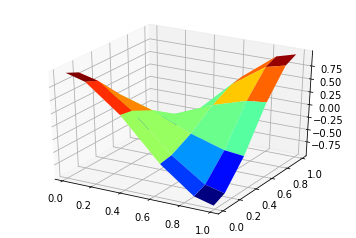

In [8]:
u_exact = lambda x,y,z: cos(pi*x)*cos(pi*y)*cos(pi*z)

X, Y = meshgrid(cheb,cheb)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(X, Y, sol[:,:,0], cmap = cm.jet)
plt.show()

In [135]:
# mod